# Contents: <a class="anchor" id="top"></a>
### [Part A: Preprocessing and PCA](#p1)
### [Part B: Model Performance](#p2) 
### [Part C: Unsupervised Learning](#p3) 
### [Part D: Data Visualization](#p4) 

# Part A: Preprocessing and PCA <a class="anchor" id="p1"></a>
[back to top](#top)

### Prompt:
A1. Develop a data pre-processing pipeline focusing on missing value handling, outlier detection, and categorical variable encoding.

A2. Implement PCA as a dimensionality reduction technique (95%) to reduce the number of features while retaining relevant information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
df = pd.read_csv('../data/E-commerce Customer Behavior.csv')

In [3]:
df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14.0,4.6,True,25.0,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11.0,4.1,False,18.0,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9.0,3.4,True,42.0,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19.0,4.7,False,12.0,Satisfied
4,105,Male,27,Miami,Silver,720.40,13.0,4.0,True,55.0,Unsatisfied


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               337 non-null    float64
 6   Items Purchased           349 non-null    float64
 7   Average Rating            342 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  342 non-null    float64
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 27.8+ KB


In [5]:
df.isna().sum()

Customer ID                  0
Gender                       0
Age                          0
City                         0
Membership Type              0
Total Spend                 13
Items Purchased              1
Average Rating               8
Discount Applied             0
Days Since Last Purchase     8
Satisfaction Level           2
dtype: int64

#### How to handle missing values in the 'Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase' columns:
- Note that there is only one record for every customer, thus there is no history for a customer we can use to infer about their behavior. Thus there is no real good way to impute the NA values in these columns besides using the median value of the columns. 
- Note that using the median is robust to outliers in future data

In [6]:
# same number of columns as original df
print('number unique customers: ', df['Customer ID'].unique().size)

print('original df shape: ', df.shape)

number unique customers:  350
original df shape:  (350, 11)


In [7]:
# subset numeric columns of df
nadf = df[['Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']]
print('numeric data NA totals:')
print(nadf.isna().sum())
print()

# fill NA's with median value
nadf = nadf.fillna(nadf.median())
print('numeric data NA totals:')
print(nadf.isna().sum())
print()

# replace NAs in original df
df[['Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']] = nadf
print('full nf NA totals:')
print(df.isna().sum())

numeric data NA totals:
Total Spend                 13
Items Purchased              1
Average Rating               8
Days Since Last Purchase     8
dtype: int64

numeric data NA totals:
Total Spend                 0
Items Purchased             0
Average Rating              0
Days Since Last Purchase    0
dtype: int64

full nf NA totals:
Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64


#### Satisfaction Level Impute NA
- Since the distribution of satisfaction level is fairly even, we can just impute one NA as 

In [8]:
from numpy.random import choice

num_na = df['Satisfaction Level'].isna().sum()
i = df['Satisfaction Level'].value_counts().index
v = df['Satisfaction Level'].value_counts().values

# make a prob. dist.
v = v/sum(v)

# draw from dist.
draw = choice(i, num_na, p=v)

# replace the NAs in the df
df.loc[df['Satisfaction Level'].isna(), 'Satisfaction Level'] = draw

# print NA count
print('full nf NA totals:')
print(df.isna().sum())

full nf NA totals:
Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          0
dtype: int64


### Outlier Detection:
- Use z-score to remove any outliers

In [9]:
df.columns

Index(['Customer ID', 'Gender', 'Age', 'City', 'Membership Type',
       'Total Spend', 'Items Purchased', 'Average Rating', 'Discount Applied',
       'Days Since Last Purchase', 'Satisfaction Level'],
      dtype='object')

In [11]:
from scipy import stats

# subset numeric columns from df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df.select_dtypes(include=numerics)

# make a df with z-scores of each row and column
z = np.abs(stats.zscore(numdf))

# set a threshold for the z-score you want to remove, in particular, remove data with values 
## more than 4 standard deviations away from the mean
threshold_z = 4.0

# find and remove outliers
outlier_indices = np.where(z > threshold_z)
print('df number of rows: ', df.shape[0])
print()
print('Outlier rows:')
print(df.iloc[outlier_indices[0],:])
print()

df = df.drop(outlier_indices[0])
print('df number of rows without outliers: ', df.shape[0])


df number of rows:  350

Outlier rows:
Empty DataFrame
Columns: [Customer ID, Gender, Age, City, Membership Type, Total Spend, Items Purchased, Average Rating, Discount Applied, Days Since Last Purchase, Satisfaction Level]
Index: []

df number of rows without outliers:  350


### Encoding Categorical Variables
- Encode ordinal categorical variables
- Change 'Gender' column to binary 'isMale' column
- Convert boolean column to integer
- Drop customerID as it is categorical but holds no predictive value
- One-hot encode city variable 

In [12]:
# create categorical maps
membership_map = {'Bronze':0, 'Silver':1, 'Gold':2}
satisfaction_map = {'Unsatisfied': 0, 'Neutral':1, 'Satisfied':2}
gender_map = {'Female':0, 'Male':1}

# apply mappings and replace boolean with integer representation
df['Membership Type'] = df['Membership Type'].replace(membership_map)
df['Satisfaction Level'] = df['Satisfaction Level'].replace(satisfaction_map)
df['Gender'] = df['Gender'].replace(gender_map)
df['Discount Applied'] = df['Discount Applied'].apply(lambda x: int(x))

# change name of gender column 
df.rename(columns={'Gender':'isMale'})

# OHE city column 
city_ohe = pd.get_dummies(df[['City']])
df = pd.concat([df,city_ohe], axis=1)

# drop customerID column and City column
df = df.drop(columns=['Customer ID', 'City'])

In [13]:
df.head(3)

,Gender,Age,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,City_Chicago,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco
0,0,29,2,1120.20,14.0,4.6,1,25.0,2,0,0,0,0,1,0
1,1,34,1,780.50,11.0,4.1,0,18.0,1,0,0,1,0,0,0
2,0,43,0,510.75,9.0,3.4,1,42.0,0,1,0,0,0,0,0


In [14]:
df.to_numpy()

array([[ 0., 29.,  2., ...,  0.,  1.,  0.],
       [ 1., 34.,  1., ...,  0.,  0.,  0.],
       [ 0., 43.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., 30.,  2., ...,  0.,  1.,  0.],
       [ 1., 34.,  1., ...,  0.,  0.,  0.],
       [ 0., 43.,  0., ...,  0.,  0.,  0.]])

## Apply PCA

In [15]:
# standardize the dataset
from sklearn.preprocessing import StandardScaler
X_normal = StandardScaler().fit_transform(df)

# apply PCA using sklearn
from sklearn.decomposition import PCA

pca = PCA(n_components=X_normal.shape[1])

principalComponents = pca.fit_transform(X_normal)
principalDf = pd.DataFrame(data = principalComponents)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC' + str(i+1) for i in range(X_normal.shape[1])])

In [16]:
# observe explained variance of each principal component
explained_variance = pca.explained_variance_ratio_
component_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance
})
component_variance_df.round(4)

,Principal Component,Explained Variance
0,PC1,0.4466
1,PC2,0.1911
2,PC3,0.1523
3,PC4,0.1004
4,PC5,0.0863
5,PC6,0.0101
6,PC7,0.0038
7,PC8,0.0031
8,PC9,0.0026
9,PC10,0.0015


In [17]:
# observe the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

cumulative_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(cumulative_variance))],
    'Cumulative Variance': cumulative_variance
})

cumulative_variance_df.round(4).head(7)

,Principal Component,Cumulative Variance
0,PC1,0.4466
1,PC2,0.6377
2,PC3,0.7900
3,PC4,0.8903
4,PC5,0.9767
5,PC6,0.9868
6,PC7,0.9907


Thus in order to retain 95% of relevant information, we only need to keep the first 5 principal components.

In [18]:
finaldf = principalDf.iloc[:,0:5]
finaldf.head()

,PC1,PC2,PC3,PC4,PC5
0,1.939838,1.305654,2.449004,-1.039998,0.888679
1,0.400532,-1.428691,-1.484680,0.404131,1.973085
2,-3.658160,0.702704,0.930400,2.022145,-0.216482
3,4.000182,-0.729253,-0.332903,0.964100,-1.445787
4,-0.632842,3.055716,-2.154855,-1.038023,-0.459224


# Part B: Model Performance <a class="anchor" id="p2"></a>
[back to top](#top)


### Prompt:
B1. Perform Full Data Pre-processing:  
- Handle missing values and decide on a strategy to impute or remove them. Detect and manage outliers in the dataset. Encode categorical variables appropriately (if applicable). Normalize or standardize the numerical variables. 

B2. Model Development:  
- Split the dataset into training and testing sets. Train at least 2 different machine learning models. Optimize hyperparameters to achieve the best performance.

B3. Evaluate the models using appropriate metrics (e.g., accuracy, precision, recall).

B4. Determine which model performs the best on the testing set.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

### Preprocessing

In [20]:
df = pd.read_csv('../data/diabetes_A1.csv')

In [21]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
# observe there are no NA
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

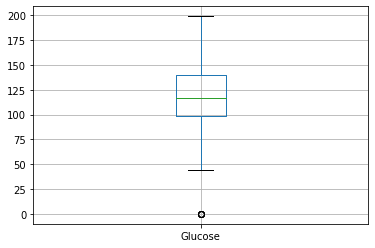

In [23]:
# observe there is a record of a patient with zero Glucose, this must be an error
df[['Glucose']].boxplot();

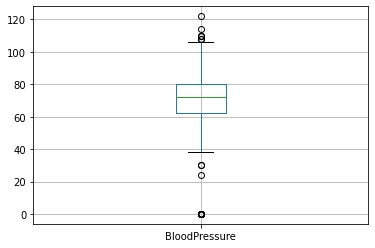

In [24]:
# observe there is a record of a patient with zero blood pressure, this must be an error
df[['BloodPressure']].boxplot();

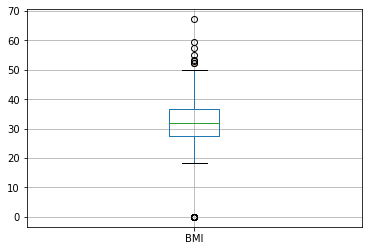

In [25]:
# observe there is a record of a patient with zero BMI, this must be an error
df[['BMI']].boxplot();

In [26]:
# drop records with human error

drop_idx = df.loc[(df['BMI']==0) | (df['BloodPressure']==0) | (df['Glucose']==0)].index
df = df.drop(drop_idx)

In [27]:
# check for outliers
from scipy import stats

# subset numeric columns from df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df.select_dtypes(include=numerics)
numdf = numdf.drop(columns=['Outcome'])

# make a df with z-scores of each row and column
z = np.abs(stats.zscore(numdf))

# set a threshold for the z-score you want to remove
threshold_z = 4.5

# find and remove outliers
outlier_indices = np.where(z > threshold_z)
print('df number of rows: ', df.shape[0])
print('Outlier rows:')
print(df.iloc[outlier_indices[0],:])
print()

# df = df.drop(outlier_indices[0])
# print('df number of rows: ', df.shape[0])


df number of rows:  724
Outlier rows:
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
4              0      137             40             35      168  43.1   
13             1      189             60             23      846  30.1   
177            0      129            110             46      130  67.1   
228            4      197             70             39      744  36.7   
228            4      197             70             39      744  36.7   
247            0      165             90             33      680  52.3   
370            3      173             82             48      465  38.4   
445            0      180             78             63       14  59.4   
579            2      197             70             99        0  34.7   

     DiabetesPedigreeFunction  Age  Outcome  
4                       2.288   33        1  
13                      0.398   59        1  
177                     0.319   26        1  
228                     2.329   31   

The outliers identified above do not seem to be caused by human error so I will decide to leave them in the dataset.

In [28]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [29]:
# standardize the numerical values
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,:-1]
X_normal = StandardScaler().fit_transform(X)

# create a new normalized dataframe
normal_df = pd.DataFrame(X_normal, columns=df.columns[:-1])

# concatenate with outcome column
normal_df = pd.concat([normal_df, df[['Outcome']]], axis=1)

In [30]:
normal_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.635022,0.849933,-0.032378,0.862278,-0.722572,0.164562,0.458421,1.416075,1.0
1,-0.852861,-1.200262,-0.517370,0.480644,-0.722572,-0.852262,-0.372691,-0.199947,0.0
2,1.230175,1.988930,-0.679035,-1.363918,-0.722572,-1.331622,0.593928,-0.114893,1.0
3,-0.852861,-1.070091,-0.517370,0.099010,0.081288,-0.634371,-0.926765,-1.050485,0.0
4,-1.150438,0.491962,-2.619006,0.862278,0.714115,1.544537,5.460146,-0.029839,1.0


In [31]:
normal_df.isna().sum()

Pregnancies                 44
Glucose                     44
BloodPressure               44
SkinThickness               44
Insulin                     44
BMI                         44
DiabetesPedigreeFunction    44
Age                         44
Outcome                     44
dtype: int64

In [32]:
# drop NA
normal_df = normal_df.dropna()

### Modeling

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [34]:
y = normal_df['Outcome']
X = normal_df.iloc[:,:-1]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2001)

#### Decision Tree

In [36]:
# create a Decision Tree using entropy as attribute selection
DT_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)

# training the tree
DT_clf = DT_clf.fit(X_train, y_train)

# generate predictions
y_pred = DT_clf.predict(X_test)

# print overall accuracy
print('Decision Tree Accuracy:', sum(y_pred == y_test)/len(y_pred))

Decision Tree Accuracy: 0.6568627450980392


In [37]:
c_mat = confusion_matrix(y_test, y_pred)
c_mat

array([[134,   0],
       [ 70,   0]])

In [38]:
F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('DT F1 Score:', F1_score)
print('DT Precision:', precision)
print('DT Recall:', recall)

DT F1 Score: 0.0
DT Precision: 0.6568627450980392
DT Recall: 1.0


#### Optimize Parameters

In [39]:
# grid search
from sklearn.model_selection import GridSearchCV

tree_params_grid = {'criterion':['gini','entropy'],
                    'max_depth':[8,10,12,14]}
DT_clf = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=tree_params_grid, cv=5)
DT_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 10, 12, 14]})

In [40]:
DT_clf.best_params_

{'criterion': 'entropy', 'max_depth': 12}

#### Best DT Model

In [49]:
# create a Decision Tree using entropy as attribute selection
DT_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=12)

# training the tree
DT_clf = DT_clf.fit(X_train, y_train)

# generate predictions
y_pred = DT_clf.predict(X_test)

# print overall accuracy
print('Decision Tree Accuracy:', sum(y_pred == y_test)/len(y_pred))

F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('DT F1 Score:', F1_score)
print('DT Precision:', precision)
print('DT Recall:', recall)

Decision Tree Accuracy: 0.5882352941176471
DT F1 Score: 0.4473684210526316
DT Precision: 0.6568627450980392
DT Recall: 1.0


#### Logistic Regression

In [41]:
# create a LR classifier
LR_clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# generate predictions
y_pred = LR_clf.predict(X_test)

# print overall accuracy
print('Logistic Reg. Accuracy:', sum(y_pred == y_test)/len(y_pred))

Logistic Reg. Accuracy: 0.6568627450980392


In [42]:
c_mat = confusion_matrix(y_test, y_pred)
c_mat

array([[134,   0],
       [ 70,   0]])

In [43]:
F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('Logistic Regression F1 Score:', F1_score)
print('Logistic Regression Precision:', precision)
print('Logistic Regression Recall:', recall)

Logistic Regression F1 Score: 0.0
Logistic Regression Precision: 0.6568627450980392
Logistic Regression Recall: 1.0


#### Optimize Parameters

In [44]:
LR_grid = {'penalty': ['l1','l2'], 
           'C': [0.1,1,10]}
LR_clf = GridSearchCV(estimator=LogisticRegression(), param_grid=LR_grid, cv=5)
LR_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']})

In [45]:
LR_clf.best_params_

{'C': 0.1, 'penalty': 'l2'}

#### Best LR Model

In [46]:
# create a LR classifier
LR_clf = LogisticRegression(random_state=0, C=0.1, penalty='l2').fit(X_train, y_train)

# generate predictions
y_pred = LR_clf.predict(X_test)

# print overall accuracy
print('Logistic Reg. Accuracy:', sum(y_pred == y_test)/len(y_pred))

Logistic Reg. Accuracy: 0.6568627450980392


In [47]:
c_mat = confusion_matrix(y_test, y_pred)
c_mat

array([[134,   0],
       [ 70,   0]])

In [48]:
F1_score = f1_score(y_test, y_pred)
precision = c_mat[0,0] / (c_mat[0,0]+c_mat[1,0])
recall = c_mat[0,0] / (c_mat[0,0]+c_mat[0,1])

print('Logistic Regression F1 Score:', F1_score)
print('Logistic Regression Precision:', precision)
print('Logistic Regression Recall:', recall)

Logistic Regression F1 Score: 0.0
Logistic Regression Precision: 0.6568627450980392
Logistic Regression Recall: 1.0


The results idicate that the Logistic Regression mmodel has better overall accuracy and the Decision Tree model has the better F1 score. In the context of predicting diabetes, false positives are more favorable than false negatives, thus we would likely opt to use the Decision Tree model, as F1-score is a more appropriate metric for considering the harmful effects of false negatives, i.e. failing to diagnose a patient with diabetes when they truly have the disease.

# Part C: UNSUPERVISED LEARNING <a class="anchor" id="p3"></a>
[back to top](#top)

### Prompt:
You are tasked with performing customer segmentation using unsupervised learning techniques on a given dataset. The dataset contains various attributes of customers, such as gender, marital status, age, education, work experience, spending score, and family size.

Here's an explanation of each column in the dataset:

* **ID**: Unique identifier for each customer.
* **Gender**: Gender of the customer. It can be either 'Male' or 'Female'.
* **Ever_Married**: Indicates if the customer is married or not. It can have two values: 'Yes' or 'No'.
* **Age**: Age of the customer at the time of data collection.
* **Graduated**: Indicates if the customer has a degree or not. It can have two values: 'Yes' or 'No'.
* **Work_Experience**: The work experience of the customer in years.
* **Spending_Score**: A variable indicating how much a customer spends. It could be categorized into different levels like 'Low', 'Average', or 'High'.
* **Family_Size**: Total number of people in the customer's family.

Using the following instructions, perform unsupervisied learning on the given dataset.

**NOTE: DO NOT REMOVE THE COMMENTS DESCRIBING THE TASK. A PENALTY OF 3 POINTS WILL BE GIVEN IF DELETED. ADD EXTRA CODE CELLS IF REQUIRED**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

## C1 - (3 points)

This is the easy part. Reading the dataset and describe it.  

In [2]:
#ADD YOUR CODE TO READ THE DATASET (0.5 points)
df = pd.read_csv('../data/Customer_Dataset.csv')

In [3]:
#ADD YOUR CODE TO PRINT THE DESCRIPTION OF THE DATASET (0.5 points)
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


In [4]:
#ADD YOUR CODE TO PRINT THE INFO (0.5 points)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 567.4+ KB


In [5]:
#ADD YOUR CODE TO SHOW THE COUNT OF UNIQUE VALUES FOR EACH CATEGORICAL VARIABLE (0.5 points)
for colname in ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']:
    print('Attribute: ', colname)
    print('Number of unique column values: ', len(df[colname].unique()))
    print(df[colname].value_counts())
    print('-------------------------------------------------------------')

Attribute:  Gender
Number of unique column values:  2
Male      4417
Female    3651
Name: Gender, dtype: int64
-------------------------------------------------------------
Attribute:  Ever_Married
Number of unique column values:  3
Yes    4643
No     3285
Name: Ever_Married, dtype: int64
-------------------------------------------------------------
Attribute:  Graduated
Number of unique column values:  3
Yes    4968
No     3022
Name: Graduated, dtype: int64
-------------------------------------------------------------
Attribute:  Profession
Number of unique column values:  10
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: Profession, dtype: int64
-------------------------------------------------------------
Attribute:  Spending_Score
Number of unique column values:  3
Low        4878
Average    1974
High       1216
Name: Spending_

In [6]:
#ADD YOUR CODE TO PRINT THE COUNT OF NAN VALUES IN EACH COLUMN (0.5 points)
df.isna().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [7]:
#ADD YOUR CODE TO DROP THE ID COLUMN (0.5 points)
df = df.drop(columns=['ID'])

## C2 - (7 points)

This part is concerned with data cleaning

In [8]:
df.head(2)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0


In [9]:
#ADD YOUR CODE TO REPLACE NAN VALUES IN THE 'Ever_Married' AND 'Graduated' COLUMNS WITH THEIR MODE (2 points)
df['Ever_Married'].fillna(df['Ever_Married'].mode()[0], inplace=True)
df['Graduated'].fillna(df['Graduated'].mode()[0], inplace=True)

In [10]:
df.isna().sum()

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [11]:
#ADD YOUR CODE TO REPLACE NAN VALUES IN THE 'Profession' COLUMN WITH THE STRING 'Unknown' (1 Point)
df['Profession'].fillna('Unknown', inplace=True)

In [12]:
df.isna().sum()

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [13]:
#ADD YOUR CODE TO PRINT THE AVERAGE WORK EXPERIENCE FOR EACH PROFESSION (1 point)
avg_work_by_pro = df.groupby('Profession').mean()['Work_Experience']
avg_work_by_pro

Profession
Artist           2.708460
Doctor           2.622222
Engineer         2.595541
Entertainment    2.755220
Executive        2.327652
Healthcare       2.592061
Homemaker        6.464455
Lawyer           1.229630
Marketing        2.616601
Unknown          2.397959
Name: Work_Experience, dtype: float64

In [14]:
#ADD YOUR CODE TO REPLACE NAN VALUES IN THE 'Work_Experience' COLUMN WITH
#THE AVERAGE WORK EXPERIENCE VALUE FOR THE CORRESPONDING PROFESSION (2 point)
mapp = dict(avg_work_by_pro)

df['Work_Experience'].fillna(df['Profession'].map(mapp), inplace=True)

In [15]:
df.isna().sum()

Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession           0
Work_Experience      0
Spending_Score       0
Family_Size        335
dtype: int64

In [16]:
#ADD YOUR CODE TO REPLACE NAN VALUES IN THE 'Family_Size' COLUMN WITH ITS MEAN (1 point)
df['Family_Size'].fillna(df['Family_Size'].mean(), inplace=True)

In [17]:
df.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

## C3 - (3 points)

This part requires you to encoding and scale the dataset

In [18]:
#ADD YOUR CODE TO ENCODE THE COLUMNS
#'Gender', 'Ever_Married', 'Graduated', 'Spending_Score', 'Profession'
#USING APPROPRIATE ENCODING TECHNIQUES (2.5 points)

# create categorical maps
gender_map = {'Female':0, 'Male':1}
married_map = {'No':0, 'Yes':1}
grad_map = {'No':0, 'Yes':1}
sscore_map = {'Low': 0, 'Average':1, 'High':2}

# apply mappings and replace boolean with integer representation
df['Gender'] = df['Gender'].replace(gender_map)
df['Ever_Married'] = df['Ever_Married'].replace(married_map)
df['Graduated'] = df['Graduated'].replace(grad_map)
df['Spending_Score'] = df['Spending_Score'].replace(sscore_map)

# # change name of gender column 
# df.rename(columns={'Gender':'isMale'})

# OHE Profession column 
pro_ohe = pd.get_dummies(df[['Profession']])
df = pd.concat([df,pro_ohe], axis=1)

# drop the Profession column
df = df.drop(columns=['Profession'])


In [19]:
#ADD YOUR CODE TO SCALE THE DATASET USING MINMAXSCALER (0.5 Points)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)

In [20]:
scaled_df.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown
0,1.0,0.0,0.056338,0.0,0.071429,0.0,0.375,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.281690,1.0,0.185396,0.5,0.250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.690141,1.0,0.071429,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.690141,1.0,0.000000,1.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.309859,1.0,0.196801,1.0,0.625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## C4 - (7 points)

This part is for creating a clustering model using KMeans

In [21]:
import pandas as pd
from sklearn.cluster import KMeans

In [22]:
# returning an error when I try to use only 1 cluster and I cannot figure out why.
model = KMeans(n_clusters=1, random_state=2001)
model.fit_predict(scaled_df)

AttributeError: 'NoneType' object has no attribute 'split'

In [23]:
#ADD YOUR CODE TO FIT A KMEANS MODEL FOR n_clusters VALUES RANGING FROM 1 TO 10 (BOTH INCLUSIVE) (1 point)
#ALSO RECORD THE INERTIA VALUE FOR EVERY N_CLUSTER (1 point)

# within-cluster sum of squares
wcss = [] 
for i in range(2,11):
    model = KMeans(n_clusters=i, random_state=2001)
    y_kmeans = model.fit_predict(scaled_df)
    wcss.append(model.inertia_)  # record inter-cluster inertia

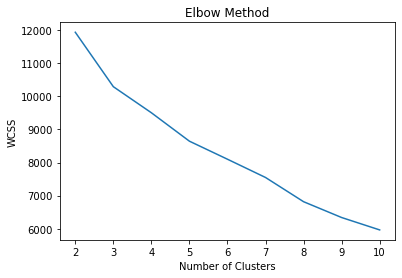

In [24]:
#USE THE ELBOW METHOD TO FIND THE OPTIMAL NUMBER OF CLUSTERS.
#PLOT A GRAPH OF N_CLUSTERS VS INERTIA AND INTERPRET THE OPTIMAL VALUE (1 point)

plt.plot(range(2,11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

#### EXPLAIN THE REASON BEHIND SELECTING THE OPTIMAL VALUE (1 point)
- The optimal number of clusters is the value after the most significant drop in the model inertia. Even if the model inertia continues to decline as we add more clusters, we would like to have the smallest number of clusters possible to increase the generalizability of the model as well as the computational speed.
- Thus, we choose to use 3 clusters.

In [25]:
#FIT A KMEANS MODEL AGAIN BASED ON THE OPTIMAL NUMBER OF CLUSTERS (1 Point)
model = KMeans(n_clusters = 3)

In [26]:
#PREDICT THE CLUSTER FOR THE ENTIRE DATASET (1 point)
y_kmeans = model.fit_predict(scaled_df)
y_kmeans

array([1, 0, 0, ..., 1, 1, 0], dtype=int32)

In [27]:
#ASSIGN THE CLUSTER TO EACH ROW OF THE DATASET, PRINT THE TOP 5 ROWS, AND SUBMIT THE DATASET. (1 point)

# store it in an actual frame
scaled_df['clusters'] = y_kmeans  
scaled_df.head()

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown,clusters
0,1.0,0.0,0.056338,0.0,0.071429,0.0,0.375,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,0.0,1.0,0.281690,1.0,0.185396,0.5,0.250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,0.690141,1.0,0.071429,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,1.0,0.690141,1.0,0.000000,1.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,1.0,0.309859,1.0,0.196801,1.0,0.625,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
scaled_df.to_csv('SP24_DM_Gabe_Wallon_Dataset.csv')

# Part D: DATA VISUALIZATION USING THE IMDB DATASET (20 POINTS) <a class="anchor" id="p4"></a>
[back to top](#top)

### Prompt:
* In this question, you are required to visualize 5 plots based on the given questions and provide relevant explanation and insights derived from the plot.
* There are 5 questions with each question asking for plot(s). Each question is worth 4 points. Here's the breakdown:
    * Each correct plot is worth 2 points
    * A good explanation of at least 4 sentences is worth 2 points
    * A partially correct plot is worth 1 point
* Make sure each plot is labelled appropriately.
* Comment out any code that prints any kind of output. We just require the final plot and the explanation to grade.
* Use additional code cells wherever required
* Now, using the given dataset, plot graphs and given your insights


Write your code to for imports and reading the dataset

In [1]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

In [2]:
#READ DATASET
df = pd.read_csv('../data/imdb_movie_dataset.csv')

In [3]:
df.head()

,movie_name,director,cast,genre,description,imdb_score,votes,rating,runtime,gross
0,Hamilton,Thomas Kail,"Leslie Odom Jr., Renée Elise Goldsberry, Phill...","Biography, Drama, History",The real life of one of America's foremost fou...,9.0,22819.0,PG-13,160.0,NaN
1,Eurovision Song Contest: The Story of Fire Saga,David Dobkin,"Will Ferrell, Rachel McAdams, Dan Stevens, Mik...","Comedy, Music",When aspiring musicians Lars and Sigrit are gi...,6.6,45555.0,PG-13,123.0,NaN
2,The Old Guard,Gina Prince-Bythewood,"Charlize Theron, Marwan Kenzari, Matthias Scho...","Action, Adventure, Fantasy",A covert team of immortal mercenaries are sudd...,6.7,43653.0,R,125.0,NaN
3,365 Days,"Tomasz Mandes, Barbara Bialowas","Michele Morrone, Bronislaw Wroclawski, Otar Sa...","Drama, Romance",Massimo is a member of the Sicilian Mafia fami...,3.3,26324.0,TV-MA,114.0,NaN
4,Greyhound,Aaron Schneider,"Tom Hanks, Stephen Graham, Matt Helm, Elisabet...","Action, Drama, History","Early in World War II, an inexperienced U.S. N...",7.1,16830.0,PG-13,91.0,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12750 entries, 0 to 12749
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie_name   12750 non-null  object 
 1   director     12750 non-null  object 
 2   cast         12750 non-null  object 
 3   genre        12750 non-null  object 
 4   description  12750 non-null  object 
 5   imdb_score   12750 non-null  float64
 6   votes        12750 non-null  float64
 7   rating       12750 non-null  object 
 8   runtime      12750 non-null  float64
 9   gross        7691 non-null   float64
dtypes: float64(4), object(6)
memory usage: 996.2+ KB


## D1:

* Visualize a bar plot to find average IMDb score for each genre
* Hints:
    * A movie can have multiple genres
    * For example, if a movie has 3 genres "Biography, Drama, History" and an imdb_score of 9.0, then assign each of this genre an imdb_score of 9.0.
    * Do the above for every movie
    * Find the average imdb_score for each genre

* Explain the insights derived from the plot.
* What are the top-5 genres?

In [46]:
# YOUR CODE
def genre_score(df):
    '''Returns a list with (genre,average_score) key-value tuples.'''
    
    # first make a set containing all the genres in the df 
    g_set = set()
    for i in range(df.shape[0]):
        g_list = df.iloc[i]['genre'].split(sep=',')
        g_list = [g.strip() for g in g_list]
        g_set.update(set(g_list))
    
    # next make a dictionary to keep track of total score and movie count per genre
    score_dict = {}
    for g in g_set:
        score_dict[g] = [0,0]  # [x=score total, y=movie count]
    
    # now populate the dictionary
    for i in range(df.shape[0]):
        g_list = df.iloc[i]['genre'].split(sep=',')
        g_list = [g.strip() for g in g_list]
        score = df.iloc[i]['imdb_score']
        for g in g_list:
            score_dict[g][0] += score # add score to genre score total
            score_dict[g][1] += 1     # add tally to genre movie count
        
    # now find the average score per genre
    avg_lst = []
    for g in score_dict.keys():
        avg_score = score_dict[g][0]/score_dict[g][1]
        avg_lst.append((g,avg_score))
    
    return avg_lst

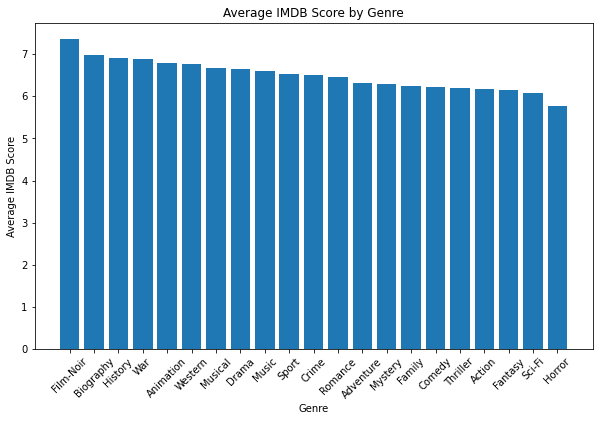

In [47]:
# YOUR CODE
# use helper function and sort the returned list by score
lst = genre_score(df)
lst.sort(key = lambda x: x[1], reverse=True)

# extract info from list
genres = [tup[0] for tup in lst]
genre_score = [tup[1] for tup in lst]

# plot
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.bar(genres,genre_score)
plt.xlabel('Genre')
plt.ylabel('Average IMDB Score')
plt.title('Average IMDB Score by Genre')
plt.show()

From this plot, we can learn that there are is not a huge variance in the average IMDB score across genres, suggesting that the genre does have a strong influence on the movie's imdb score. We can see that the top five gneres in terms of average score are:
1. Film-Noir
2. Biography
3. History
4. War
5. Animation

## D2

* This question requires 2 plots
* Find if runtime of a movie and its IMDb score are correlated or not.
* Plot No. 1: Plot a scatter plot using these columns and explain your insights.

* Plot No. 2: Plot a scatter plot between imdb score and number of votes and answer the following question:
    * Are there any movies with exceptionally high scores but low votes, or vice versa? Give names of movies having high score but less number of votes


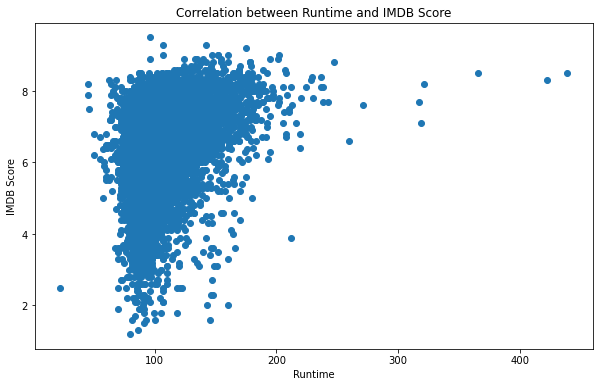

In [52]:
# YOUR CODE
# Do longer movies have a higher imdb score on average?

x = df['runtime'].values
y = df['imdb_score'].values

plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.xlabel('Runtime')
plt.ylabel('IMDB Score')
plt.title('Correlation between Runtime and IMDB Score')
plt.show()

From this plot, we can see that many short movies received very high scores however there were few long movies with low scores. This plot reveals a slight correlation between Runtime and Score, suggesting that longer movies are more likely to recieve higher scores.

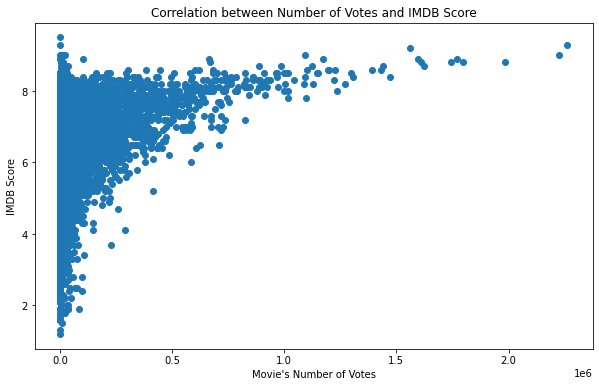

In [53]:
# YOUR CODE

x = df['votes'].values
y = df['imdb_score'].values

plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.xlabel("Movie's Number of Votes")
plt.ylabel('IMDB Score')
plt.title('Correlation between Number of Votes and IMDB Score')
plt.show()

#### Q: 
- Are there any movies with exceptionally high scores but low votes, or vice versa? Give names of movies having high score but less number of votes?

#### A: 
- From the plot we can see that there are a large number of movies that received high score from a low number of votes. In the code below, we identify these movies. There are no movies with large number of votes and small scores. 

In [64]:
x = df['votes'].values
y = df['imdb_score'].values

# find the number of votes at which only 5% of movies had less
vote_quant = np.quantile(x, 0.05)

# find the score at which only 5% of movies had greater
score_quant = np.quantile(y, 0.95)

# find the movies with votes<vote_quant and score>score_quant
df.loc[(df['votes']<vote_quant) & (df['imdb_score']>score_quant)]

,movie_name,director,cast,genre,description,imdb_score,votes,rating,runtime,gross
3357,Mariposa,Fajar Bustomi,"Angga Yunanda, Adhisty Zara, Dannia Salsabila,...","Drama, Romance",Iqbal (Angga Yunanda) is like a Mariposa butte...,8.4,45.0,R,117.000000,NaN
3520,The Killing of Two Lovers,Robert Machoian,"Clayne Crawford, Chris Coy, Bruce Graham, Arri...",Drama,David desperately tries to keep his family of ...,8.3,61.0,R,85.000000,NaN
5320,The Father,Florian Zeller,"Rufus Sewell, Anthony Hopkins, Olivia Williams...",Drama,A man refuses all assistance from his daughter...,8.4,132.0,PG-13,97.000000,NaN
7679,A Midsummer Night's Dream,"Nicholas Hytner, Ross MacGibbon","David Moorst, Oliver Chris, Isis Hainsworth, G...","Comedy, Drama, Romance","Young lovers, a troupe of actors, and fairies ...",8.5,299.0,R,180.000000,NaN
7697,Persuasion,Roger Michell,"Corin Redgrave, Ciarán Hinds, Susan Fleetwood,...",Drama,"Eight years ago, Anne Elliot rejected Frederic...",8.1,338.0,R,105.000000,NaN
8086,All About Eve,"Ivo van Hove, Nick Wickham","Lily James, Gillian Anderson, Monica Dolan, Ju...",Drama,Eve shows up in the dressing room of Broadway ...,8.2,251.0,R,148.000000,NaN
8282,Minari,Lee Isaac Chung,"Yeri Han, Yuh-Jung Youn, Steven Yeun, Alan S. Kim",Drama,A Korean family moves to Arkansas to start a f...,8.2,153.0,R,115.000000,NaN
8675,Branagh Theatre Live: Romeo and Juliet,Benjamin Caron,"Marisa Berenson, Tom Hanson, Jack Colgrave Hir...",Romance,"Two teenagers fall in love, but their feuding ...",8.1,268.0,R,165.000000,NaN
8727,Summertime,Edward Burns,"Edward Burns, Anthony Ramos, Caitlin Stasey, L...",Drama,"Summer 1983, Long Island. The daily life of yo...",8.2,39.0,R,124.000000,NaN
9027,This Day Forward,Brian Ide,"Kallen Blair, Randy Coleman, Chet Dixon, Hayde...",Family,Inspired by the true story of a wife and mothe...,9.3,64.0,R,106.805697,NaN


## D3

* Among the directors listed, who has directed the highest number of movies with gross revenue over $100$ million and imdb_score >= 7.5? Plot a bar plot for this question and provide your insights.
* Hints:
    * Drop rows with a NaN gross value.
    * Similar to Q1, a movie can have multiple directors.
    * Make sure you are considering each director separately.
    * Since there are a lot of directors, only consider those who have more than 2 movies with gross >= $100$M and imdb score >= 7.5 for the visualization
* Which director directed most number of movies? Also print the name of the movies

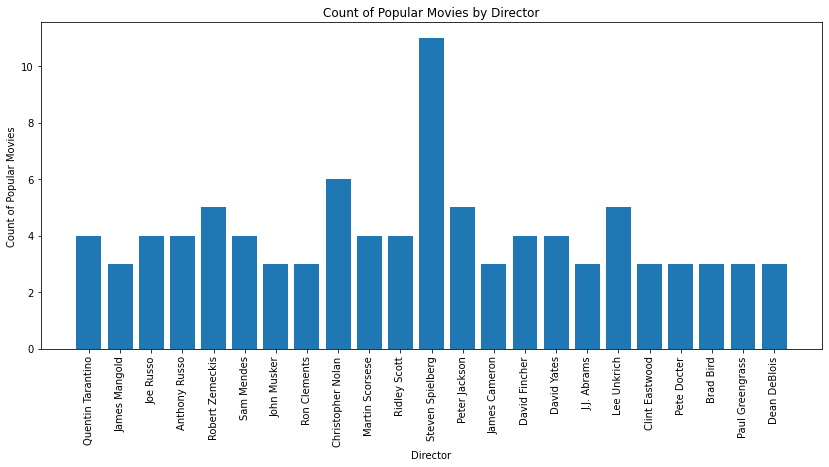

In [102]:
# YOUR CODE

# drop NA
drop_idx = np.where(df['gross'].isna().values==True)[0]
newdf = df.drop(drop_idx)

# subset df according to popularity criteria
newdf = newdf.loc[(newdf['gross']>=100) & (newdf['imdb_score']>=7.5)]

# make a dictionary with director:count key-value pairs:
# counts the number of these movies each director participated in
d_dict = {}
for i in range(newdf.shape[0]):
    d_list = newdf.iloc[i]['director'].split(sep=',')
    d_list = [d.strip() for d in d_list]
    for d in d_list:
        if d in d_dict.keys():
            d_dict[d] += 1
        else:
            d_dict[d] = 1

# subset only directors on list with count>2
high_idx = np.where(np.array(list(d_dict.values()))>2)[0]

# extract info from dictionary
d_array = np.array(list(d_dict.keys()))[high_idx]
count_array = np.array(list(d_dict.values()))[high_idx]

# plot
plt.figure(figsize=(14,6))
plt.xticks(rotation=90)
plt.bar(d_array,count_array)
plt.xlabel('Director')
plt.ylabel('Count of Popular Movies')
plt.title('Count of Popular Movies by Director')
plt.show()

From the plot above, we can see that Steven Spielberg directed the largest number of these popular movies - movies grossing at least 100M and with an imdb score of at least 7.5. These movies are shown below.

In [103]:
newdf[newdf['director']=='Steven Spielberg']

,movie_name,director,cast,genre,description,imdb_score,votes,rating,runtime,gross
88,Jaws,Steven Spielberg,"Richard Dreyfuss, Lorraine Gary, Roy Scheider,...","Adventure, Thriller",When a killer shark unleashes chaos on a beach...,8.0,532664.0,PG,124.0,260.00
90,Jurassic Park,Steven Spielberg,"Laura Dern, Richard Attenborough, Jeff Goldblu...","Action, Adventure, Sci-Fi",A pragmatic paleontologist visiting an almost ...,8.1,837960.0,PG-13,127.0,402.45
108,Saving Private Ryan,Steven Spielberg,"Matt Damon, Edward Burns, Tom Hanks, Tom Sizemore","Drama, War","Following the Normandy Landings, a group of U....",8.6,1195619.0,R,169.0,216.54
129,Ready Player One,Steven Spielberg,"Lena Waithe, Ben Mendelsohn, Olivia Cooke, Tye...","Action, Adventure, Sci-Fi",When the creator of a virtual reality called t...,7.5,349689.0,PG-13,140.0,137.69
133,Catch Me If You Can,Steven Spielberg,"Christopher Walken, Tom Hanks, Leonardo DiCapr...","Biography, Crime, Drama","A seasoned FBI agent pursues ,Frank Abagnale J...",8.1,792286.0,PG-13,141.0,164.62
250,Raiders of the Lost Ark,Steven Spielberg,"Paul Freeman, John Rhys-Davies, Karen Allen, H...","Action, Adventure","In 1936, archaeologist and adventurer Indiana ...",8.4,860417.0,PG,115.0,248.16
478,E.T. the Extra-Terrestrial,Steven Spielberg,"Peter Coyote, Drew Barrymore, Henry Thomas, De...","Family, Sci-Fi",A troubled child summons the courage to help a...,7.8,360282.0,PG,115.0,435.11
521,Minority Report,Steven Spielberg,"Samantha Morton, Colin Farrell, Tom Cruise, Ma...","Action, Crime, Mystery",In a future where a special police unit is abl...,7.6,496082.0,PG-13,145.0,132.07
611,Indiana Jones and the Temple of Doom,Steven Spielberg,"Kate Capshaw, Ke Huy Quan, Amrish Puri, Harris...","Action, Adventure","In 1935, Indiana Jones arrives in India, still...",7.6,435060.0,PG,118.0,179.87
637,Indiana Jones and the Last Crusade,Steven Spielberg,"Denholm Elliott, Sean Connery, Alison Doody, H...","Action, Adventure","In 1938, after his father Professor Henry Jone...",8.2,672893.0,PG-13,127.0,197.17


## D4

* Plot a pie chart to show distribution of imdb_scores.
* Hints
    * For imdb_score, create the following 5 bins
        * 0-5.9
        * 6-6.9
        * 7-7.9
        * 8-8.9
        * 9-9.9
    * The lower and upper bound for each bin is inclusive
    * For example, if imdb_score of a movie is 8.5, then it will belong to bin 8-8.9.
    * Show the percentage value for each slice and display the legend.

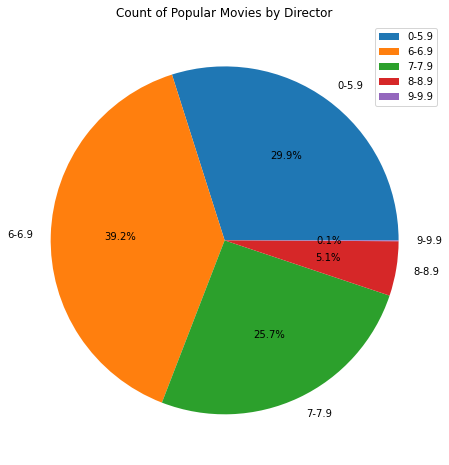

In [115]:
# YOUR CODE
x = df['imdb_score'].values
score_dict = {'0-5.9':0, '6-6.9':0, '7-7.9':0, '8-8.9':0, '9-9.9':0}

# count the number of movies in each of the score brackets
for score in x:
    if score<=5.9:
        score_dict['0-5.9']+=1
    elif score<=6.9:
        score_dict['6-6.9']+=1
    elif score<=7.9:
        score_dict['7-7.9']+=1
    elif score<=8.9:
        score_dict['8-8.9']+=1
    else:
        score_dict['9-9.9']+=1
        
# plot
plt.figure(figsize=(8,8))
plt.pie(score_dict.values(), labels=score_dict.keys(), autopct='%1.1f%%')
plt.legend()
plt.title('Count of Popular Movies by Director')
plt.show()

## D5

* Plot a box plot showing distribution of gross revenue for different movie ratings
* Hints:
    * Consider top 3 ratings with the highest frequency
    * Drop rows with gross = NaN
    * The boxplot should also include text showing lower bound, Q1, Median, Q3 and upper bound for each box
* Explain the insights obtained from the boxplot

In [127]:
# rating value counts
df['rating'].value_counts().head()

R            6070
PG-13        2275
PG           1464
Not Rated    1441
Approved      291
Name: rating, dtype: int64

Above we observe that the 3 ratings with highest frequency are 'R', 'PG-13', and 'PG'.

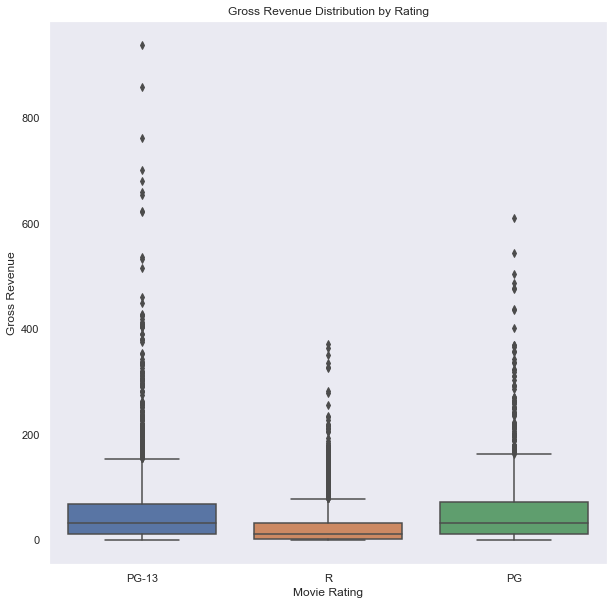

In [152]:
# YOUR CODE

# subset df
newdf = df.loc[(df['rating'] == 'R') | (df['rating'] == 'PG-13') | (df['rating'] == 'PG')]

# drop NA
newdf = newdf.dropna(subset=['gross'])

# plot
sns.set_theme(rc={'figure.figsize':(10,10)})
sns.set(style='dark', palette='deep')

ax = sns.boxplot(data=newdf, x='rating', y='gross')
ax.set_title('Gross Revenue Distribution by Rating')
ax.set_ylabel('Gross Revenue')
ax.set_xlabel('Movie Rating')
plt.show()

From the boxplots above, we can observe how the majority of the movies in every rating category had relatively low gross revenues. This makes intuitive sense as it is hard to produce a succesful movie. We can also observe how PG-13 movies have the largest revenues on average, and R movies the least, out of these three categoies.  